In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

In [2]:
df = pd.read_csv('data/anti-malware.csv')
X = df.drop(columns=['OUTPUT']).values
y = df['OUTPUT'].values

In [3]:
# Part b
from sklearn.model_selection import train_test_split

# Drop half of the dataset to reduce computational cost
X, _, y, _ = train_test_split(X, y, train_size=0.5, stratify=y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, train_size=0.8, random_state=2)

In [4]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, RocCurveDisplay
import yaml


def dprint(d):
    ctx = yaml.dump(d, allow_unicode=True, default_flow_style=False)
    print(ctx)


def eval(title, model, X_train, X_test, y_train, y_test, d=4):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='all')

    np.set_printoptions(precision=d)
    print(f"Results for {title}:")
    print('Accuracy:', round(acc, d))
    print('Recall:', round(rec, d))
    print('Confusion Matrix:')
    print(cm)

    RocCurveDisplay.from_predictions(
        y_test, model.predict_proba(X_test)[:, 1],
        name=f"{title}"
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve for {title}")
    plt.legend()
    plt.savefig(f"{title}.png")
    plt.show()


Best Parameters for Bagging with KNN:
base_estimator__metric: cosine
base_estimator__n_neighbors: 7
bootstrap_features: true

Results for Bagging with KNN:
Accuracy: 0.9609
Recall: 0.9819
Confusion Matrix:
[[0.1883 0.0249]
 [0.0142 0.7726]]


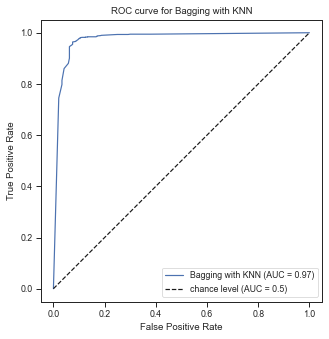

In [5]:
# Part c

gs_knn = GridSearchCV(
    estimator=BaggingClassifier(
        base_estimator=KNeighborsClassifier(),
        n_estimators=5,
        random_state=2,
    ),
    scoring='accuracy',
    cv=3,
    # n_jobs=-1,
    param_grid={
        'bootstrap_features': [True, False],
        'base_estimator__n_neighbors': [5, 7, 9, 11, 13, 15],
        'base_estimator__metric': ['minkowski', 'euclidean', 'manhattan', 'cosine'],
        # 'base_estimator__weights': ['uniform', 'distance']
    }
).fit(X_train, y_train)

print('Best Parameters for Bagging with KNN:')
dprint(gs_knn.best_params_)

eval(
    "Bagging with KNN",
    clone(gs_knn.best_estimator_),
    X_train, X_test, y_train, y_test,
)


Best Parameters for Bagging with Decision Tree:
base_estimator__max_depth: 30
bootstrap_features: true

Results for Bagging with Decision Tree:
Accuracy: 0.96
Recall: 0.974
Confusion Matrix:
[[0.1936 0.0195]
 [0.0204 0.7664]]


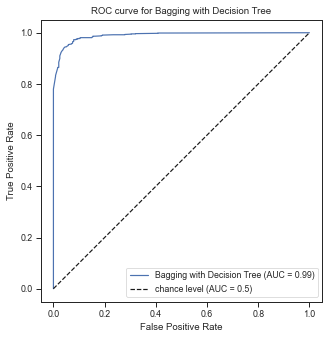

In [6]:
gs_dt = GridSearchCV(
    estimator=BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        n_estimators=55,
        random_state=2,
    ),
    scoring='accuracy',
    cv=3,
    # n_jobs=-1,
    param_grid={
        'bootstrap_features': [True, False],
        'base_estimator__max_depth': [1, 3, 5, 10, 30],
    }
).fit(X_train, y_train)

print('Best Parameters for Bagging with Decision Tree:')
dprint(gs_dt.best_params_)

eval(
    "Bagging with Decision Tree",
    clone(gs_dt.best_estimator_),
    X_train, X_test, y_train, y_test,
)


Best Parameters for AdaBoost with SVC:
base_estimator__C: 0.1

Results for AdaBoost with SVC:
Accuracy: 0.9041
Recall: 0.8928
Confusion Matrix:
[[0.2016 0.0115]
 [0.0844 0.7025]]


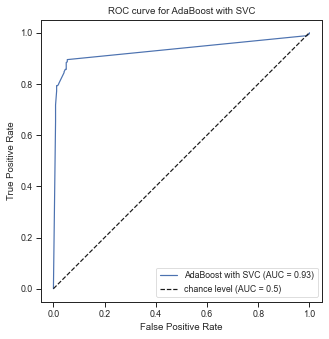

In [8]:
# Part d

gs_asvc = GridSearchCV(
    estimator=AdaBoostClassifier(
        base_estimator=SVC(kernel='linear'),
        n_estimators=20,
        random_state=2,
        algorithm='SAMME',
    ),
    scoring='accuracy',
    cv=3,
    # n_jobs=-1,
    param_grid={
        'base_estimator__C': [0.1, 1],

    }
).fit(X_train, y_train)

print('Best Parameters for AdaBoost with SVC:')
dprint(gs_asvc.best_params_)

eval(
    "AdaBoost with SVC",
    clone(gs_asvc.best_estimator_),
    X_train, X_test, y_train, y_test,
)


Best Parameters for AdaBoost with Decision Tree:
base_estimator__max_depth: 5
learning_rate: 1.0

Results for AdaBoost with Decision Tree:
Accuracy: 0.9636
Recall: 0.9752
Confusion Matrix:
[[0.1963 0.0169]
 [0.0195 0.7673]]


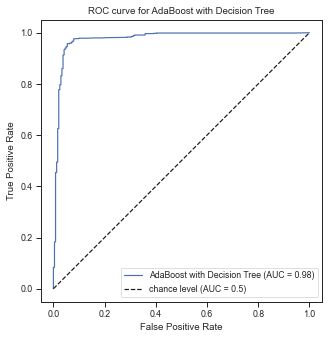

In [5]:
gs_adt = GridSearchCV(
    estimator=AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(),
        n_estimators=55,
        random_state=2,
    ),
    scoring='accuracy',
    cv=3,
    # n_jobs=-1,
    param_grid={
        'learning_rate': [0.001, 0.01, 0.1, 1.0],
        'base_estimator__max_depth': [1, 3, 5, 10],
    }
).fit(X_train, y_train)

print('Best Parameters for AdaBoost with Decision Tree:')
dprint(gs_adt.best_params_)

eval(
    "AdaBoost with Decision Tree",
    clone(gs_adt.best_estimator_),
    X_train, X_test, y_train, y_test,
)


In [6]:
# Part e
from sklearn.model_selection import StratifiedShuffleSplit

rs = StratifiedShuffleSplit(n_splits=100, train_size=0.1, random_state=2)
rs.get_n_splits(X_train, y_train)

100

In [7]:
# Part f
MODELS = (
    (55, DecisionTreeClassifier(max_depth=1)),
    (20, SVC(kernel='linear', C=0.1)),
    (15, MultinomialNB()),
    (5, KNeighborsClassifier()),
    (5, LogisticRegression()),
)

models = []
for c, m in MODELS:
    for i in range(c):
        mdl = clone(m)
        models.append(mdl)

for i, ilist in enumerate(rs.split(X_train, y_train)):
    models[i].fit(X_train[ilist[0]], y_train[ilist[0]])

In [8]:
# Part g
def extract_features(X, models):
    X_new = np.zeros((len(X), len(models)), dtype=bool)
    for i in range(X_new.shape[0]):
        for j in range(X_new.shape[1]):
            X_new[i, j] = models[j].predict([X[i]])
    return X_new


X_train_n = extract_features(X_train, models)
X_test_n = extract_features(X_test, models)

Results for SVC on Binary Dataset:
Accuracy: 0.9636
Recall: 0.9853
Confusion Matrix:
[[0.1883 0.0249]
 [0.0115 0.7753]]


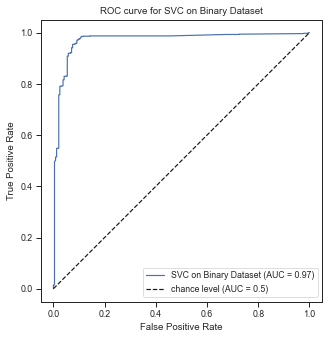

In [11]:
# Part h
eval(
    "SVC on Binary Dataset",
    SVC(probability=True),
    X_train_n, X_test_n, y_train, y_test,
)

Results for LogisticRegression on Binary Dataset:
Accuracy: 0.9583
Recall: 0.9774
Confusion Matrix:
[[0.1892 0.024 ]
 [0.0178 0.7691]]


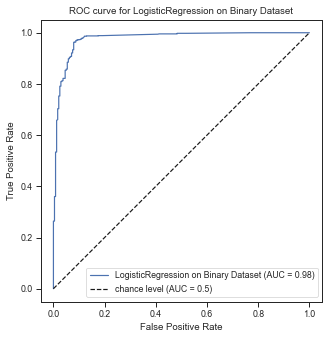

In [10]:
eval(
    "LogisticRegression on Binary Dataset",
    LogisticRegression(),
    X_train_n, X_test_n, y_train, y_test,
)